Define the base cosmology, which is the Planck 2018 cosmology. 

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
from astropy.cosmology import Planck18 as planck
import camb
from camb import model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# import colossus for HMF definition 
from colossus.cosmology import cosmology as cc
from colossus.lss import mass_function

### Define baseline cosmology for `camb` $P_{\rm lin} (k)$ and the `colossus` HMF. 

In [38]:
pars = camb.set_params(H0=planck.H0.value, 
                       ombh2=planck.Ob0 * planck.h**2, 
                       omch2=planck.Odm0 * planck.h**2, 
                       mnu=planck.m_nu.value[-1], 
                       num_nu_massive = (planck.m_nu.value > 0).sum(),
                       omk=planck.Ok0, 
                       tau=0.0543, As=np.exp(3.0448)/10**10, ns=0.96605, #Plik best fit Planck 2018 Table 1 left-most col 1807.06209
                       halofit_version='mead', lmax=2000)

In [39]:
colossus_planck_cosmo = cc.fromAstropy(astropy_cosmo = planck, 
                      sigma8 = 0.809, # based on CAMB using the As 
                      ns = 0.96605, 
                      cosmo_name = 'planck_baseline')

/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/colossus/cosmology/cosmology.py:3338: UserWarning: Astropy cosmology class contains massive neutrinos, which are not taken into account in Colossus.
  warnings.warn('Astropy cosmology class contains massive neutrinos, which are not taken into account in Colossus.')


In [40]:
# set halo mass bins

# range from 10e7 to 10e15 to cover almost all CIB galaxies 
Mh = np.logspace(7, 15, 50)

In [41]:
# read in ELG dndz 
dndz = pd.read_csv("data/gal/elg_fuji_pz_single_tomo.csv")
z = dndz['Redshift_mid'].values
z_with_0 = np.zeros(len(z) + 1)
z_with_0[1:] = z

## Preprocess for ELGs

### Calculate $P_{\rm lin} (k)$

In [23]:
pars.set_matter_power(redshifts = z_with_0, kmax=10.0)

Note: redshifts have been re-sorted (earliest first)


class: <CAMBparams>
 WantCls = True
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = False
   kmax = 10.0
   k_per_logint = 0
   PK_num_redshifts = 31
   PK_redshifts = [2.950000000000001, 2.8500000000000014, 2.750000000000001, 2.650000000000001, 2.5500000000000007, 2.450000000000001, 2.3500000000000005, ...]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2150
 max_l_tensor = 600
 max_eta_k = 5375.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.0224178568132
 omch2 = 0.11934063901639999
 omk = 0.0
 omnuh2 = 0.000644866570625114
 H0 = 67.66
 TCMB = 2.7255
 YHe = 0.2458759299699272
 num_nu_massless = 2.0293333333333337
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0146666666

In [24]:
#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=3, 
                                              npoints = 400) #FIXME this is in units of little h

In [26]:
results.get_sigma8_0()

0.8093107469735158

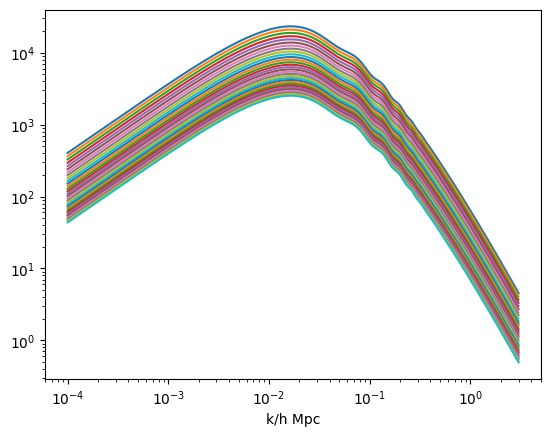

In [51]:
for i in range(len(z)):
    plt.loglog(kh, pk[i,:])
plt.xlabel('k/h Mpc');
#plt.legend(['linear','non-linear'], loc='lower left');
#plt.title('Matter power at z=%s and z= %s'%tuple(z));

In [29]:
# dictionary to store with relevant information 
plin_dict = {}

plin_dict['z'] = z
plin_dict['kh'] = kh
plin_dict['pk'] = pk

In [30]:
with open('data/plin_unit_h.p', 'wb') as handle:
    pickle.dump(plin_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Calculate HMF (z)

In [34]:
from colossus.lss import mass_function

In [43]:
cc.setCurrent(colossus_planck_cosmo) # set cosmology defn

hmfz = np.zeros((len(z_with_0), len(Mh))) #HMF of shape (z, Mh)

for i in range(len(z_with_0)):
    hmfz[i] = mass_function.massFunction(x = Mh,
                           z = z_with_0[i],
                           mdef = '200m',
                           model = 'tinker08',
                           q_in = 'M',
                           q_out = 'dndlnM')

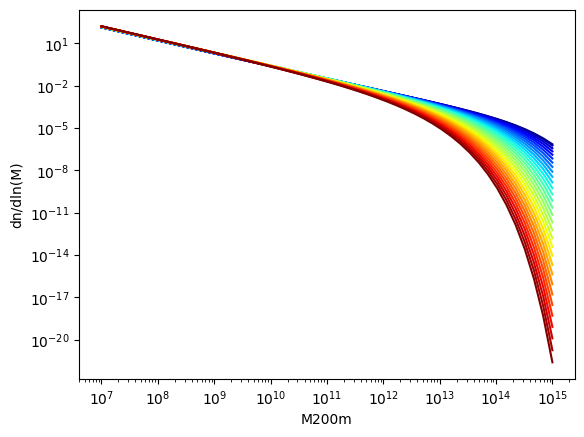

In [81]:
plt.xlabel('M200m')
plt.ylabel('dn/dln(M)')

colors = plt.cm.jet(c)
for i in range(len(z_with_0)):
    plt.loglog(Mh, hmfz[i], '-', label = 'z = %.1f' % (z_with_0[i]),
             color = colors[i])

In [85]:
# save hmf dictionary information
hmfz_dict = {}
hmfz_dict['z'] = z_with_0
hmfz_dict['Mh'] = Mh
hmfz_dict['hmfz'] = hmfz

In [86]:
with open('data/hmfz.p', 'wb') as handle:
    pickle.dump(hmfz, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Test codes

In [50]:
import numpy as np
import gal_prop as gp
import consts
import matplotlib.pyplot as plt

In [51]:
Mh = np.logspace(11, 14, 50)

/Users/tkarim/Documents/research/cib.nosync/gal_prop.py:83: RuntimeWarning: invalid value encountered in power
  return As * power_term**alpha


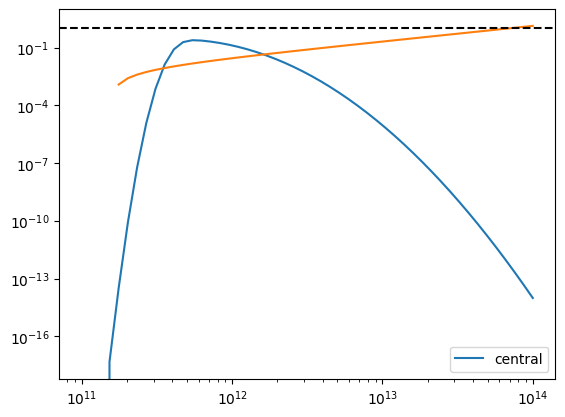

In [52]:
plt.plot(Mh, gp.Ncen(Mh), label = 'central')
plt.plot(Mh, gp.Nsat(Mh))
plt.legend(loc = 'best')
plt.xscale("log")
plt.yscale("log")
plt.axhline(1, c = 'k', ls = '--')

In [28]:
np.log10(Mh) - 11.83

array([-1.83      , -1.74836735, -1.66673469, -1.58510204, -1.50346939,
       -1.42183673, -1.34020408, -1.25857143, -1.17693878, -1.09530612,
       -1.01367347, -0.93204082, -0.85040816, -0.76877551, -0.68714286,
       -0.6055102 , -0.52387755, -0.4422449 , -0.36061224, -0.27897959,
       -0.19734694, -0.11571429, -0.03408163,  0.04755102,  0.12918367,
        0.21081633,  0.29244898,  0.37408163,  0.45571429,  0.53734694,
        0.61897959,  0.70061224,  0.7822449 ,  0.86387755,  0.9455102 ,
        1.02714286,  1.10877551,  1.19040816,  1.27204082,  1.35367347,
        1.43530612,  1.51693878,  1.59857143,  1.68020408,  1.76183673,
        1.84346939,  1.92510204,  2.00673469,  2.08836735,  2.17      ])

In [29]:
import scipy.special as ss

In [54]:
from colossus.lss import mass_function

In [56]:
from colossus.cosmology import cosmology as cc

In [58]:
cc.setCosmology('planck18')

In [71]:
hmf = mass_function.massFunction(Mh,
                           ,
                           q_in='M',
                           q_out='dndlnM',
                           model='tinker08',
                           mdef='200m')

TypeError: unsupported operand type(s) for +: 'float' and 'list'

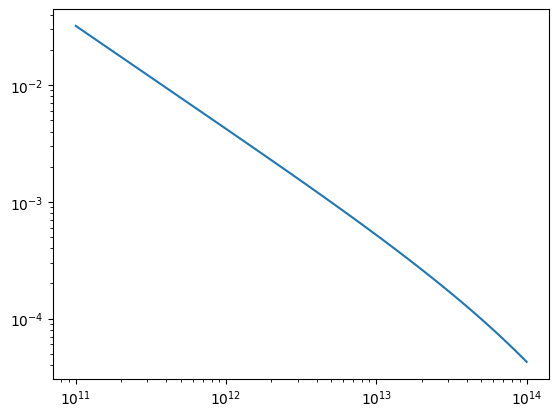

In [70]:
plt.loglog(Mh, hmf)